In [2]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import CSVLogger
from torch.utils.data import *
from collections.abc import Iterable
from ..data_utils import *

In [3]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=32, steps=1)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=32, steps=1)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=32, steps=1)

In [4]:
batch_size = 6
device = 'cuda'
folder_to_save_models = 'weights'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [5]:
from vunet_model_conv1d import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=32)

In [5]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard, valid_leaderboard2], model_dir=folder_to_save_models, cbs=CSVLogger)

In [6]:
learn.summary()

Net1 (Input shape: 6 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

In [7]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary()

In [8]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,110.652817,4.828396,0.003629,0.003629,33:36
1,42.732708,0.109388,0.002523,0.002523,33:34


In [9]:
learn.save('Comb_2')

Path('weights/Comb_2.pth')

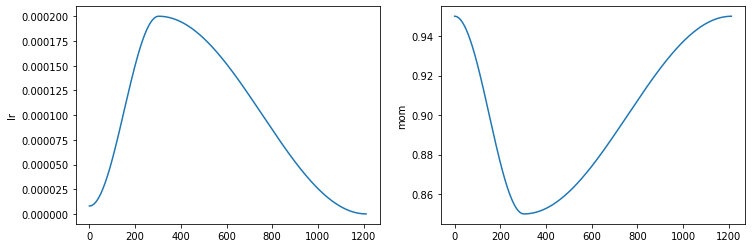

In [10]:
learn.recorder.plot_sched()

In [12]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.251354,0.095048,0.001316,0.001316,32:35
1,0.076558,0.002068,0.001418,0.001418,33:20


In [13]:
learn.save('Comb_4')

Path('weights/Comb_4.pth')

In [14]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.102324,0.061777,0.001814,0.001814,33:50
1,0.034046,0.001675,0.001352,0.001352,33:02


In [15]:
learn.save('Comb_6')

Path('weights/Comb_6.pth')

In [ ]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

In [ ]:
learn.save('Comb_8')

In [ ]:
learn.load('Comb_8')

In [6]:
# get prediction
learn = Learner(test_data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard], model_dir=folder_to_save_models, cbs=CSVLogger)
learn.load('Comb_6')
preds, targets = learn.get_preds(0)

KeyboardInterrupt: 

In [ ]:
preds, targets = learn.get_preds(2)

In [ ]:
sample, sam_targets = preds[0][0], targets[0]
sample = recover(sample, 17, 32)
sam_targets = recover(sam_targets, 17, 32)
print(sample)

i = 1
img = sample[i]
tar = sam_targets[i]
plt.subplot(1,2,1)
plt.imshow(img, cmap='jet')
plt.subplot(1,2,2)
plt.imshow(tar, cmap='jet')

In [ ]:
h = h5py.File(root, 'r')['samples']
sample = h[-64:,:256,:256].astype(np.float32)
sample = rescale(sample, 17, 32)
pred = learn.predict(sample[np.newaxis,:32])